# FastAI Experiments Using Google Colab CPU

<a href="https://colab.research.google.com/github/rambasnet/DeepLearningMaliciousURLs/blob/master/FastAI-Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [1]:
from fastai.tabular import *
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import os
import sys
import glob
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn import model_selection

### Note Notebook doesn't display all the rows and columns
- let's fix that

In [7]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

## Check CSV files inside FinalDataset folder
- if it doesn't exists, download data using Bash script in Baseline-Experiments notebook

In [4]:
! ls FinalDataset

All.csv                      Malware_Infogain_test.csv
All.csv.pickle               Phishing.csv
All_BestFirst.csv            Phishing_BestFirst.csv
All_BestFirst_test.csv       Phishing_Infogain.csv
All_Infogain.csv             Phishing_Infogain_test.csv
All_Infogain_test.csv        Spam.csv
Defacement.csv               Spam_BestFirst.csv
Defacement_BestFirst.csv     Spam_BestFirst_test.csv
Defacement_Infogain.csv      Spam_Infogain.csv
Defacement_Infogain_test.csv Spam_Infogain_test.csv
Malware.csv                  URL
Malware_BestFirst.csv        models
Malware_Infogain.csv


In [48]:
def loadData(csvFile):
    pickleDump = '{}DroppedNaNCols.pickle'.format(csvFile)
    if os.path.exists(pickleDump):
        df = pd.read_pickle(pickleDump)
    else:
        df = pd.read_csv(csvFile, low_memory=False)
        # clean data
        # strip the whitspaces from column names
        df = df.rename(str.strip, axis='columns')
        # drop Infinity rows and NaN string from each column
        for col in df.columns:
            indexNames = df[df[col] == 'Infinity'].index
            if not indexNames.empty:
                print('deleting {} rows with Infinity in column {}'.format(len(indexNames), col))
                df.drop(indexNames, inplace=True)
            
        df.argPathRatio = df['argPathRatio'].astype('float')
        # drop all columns with NaN values
        beforeColumns = df.shape[1]
        df.dropna(axis='columns', inplace=True)
        print('Dropped {} columns with NaN values'.format(beforeColumns - df.shape[1]))
        # drop all rows with NaN values
        beforeRows = df.shape[0]
        df.dropna(inplace=True)
        print('Dropped {} rows with NaN values'.format(beforeRows - df.shape[0]))
        df.to_pickle(pickleDump)
        
    return df

In [49]:
df = loadData('FinalDataset/All.csv')

/Users/rbasnet/miniconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


deleting 10 rows with Infinity in column argPathRatio
Dropped 7 columns with NaN values
Dropped 0 rows with NaN values


In [50]:
# let's check the shape again
df.shape

(36697, 73)

In [52]:
# class distribution for original data
label = 'URL_Type_obf_Type'
print(df.groupby(label).size())

URL_Type_obf_Type
Defacement    7930
benign        7781
malware       6711
phishing      7577
spam          6698
dtype: int64


## Experimenting with FinalDataset/All.csv

## Multi-class classification

## Total samples for each class

In [53]:
dataPath = 'FinalDataset'
dep_var = label
cat_names = []
cont_names = list(set(df.columns) - set(cat_names) - set([dep_var]))

In [54]:
cont_names

['File_name_DigitCount',
 'ldl_getArg',
 'isPortEighty',
 'URL_DigitCount',
 'SymbolCount_Afterpath',
 'avgdomaintokenlen',
 'dld_url',
 'tld',
 'charcompvowels',
 'ldl_filename',
 'pathDomainRatio',
 'Path_LongestWordLength',
 'SymbolCount_FileName',
 'executable',
 'delimeter_path',
 'Entropy_URL',
 'LongestPathTokenLength',
 'ldl_path',
 'NumberRate_URL',
 'Querylength',
 'ldl_domain',
 'SymbolCount_Extension',
 'host_DigitCount',
 'ArgLen',
 'domain_token_count',
 'Query_LetterCount',
 'SymbolCount_URL',
 'Directory_LetterCount',
 'dld_domain',
 'Domain_LongestWordLength',
 'Query_DigitCount',
 'SymbolCount_Directoryname',
 'ArgUrlRatio',
 'path_token_count',
 'Filename_LetterCount',
 'Extension_DigitCount',
 'Directory_DigitCount',
 'host_letter_count',
 'ISIpAddressInDomainName',
 'spcharUrl',
 'NumberRate_FileName',
 'URL_sensitiveWord',
 'SymbolCount_Domain',
 'URL_Letter_Count',
 'domainlength',
 'sub-Directory_LongestWordLength',
 'subDirLen',
 'Extension_LetterCount',
 'path

In [55]:
procs = [FillMissing, Categorify, Normalize]
sss = StratifiedShuffleSplit(n_splits = 1, test_size=0.2, random_state=0)
print(sss)

StratifiedShuffleSplit(n_splits=1, random_state=0, test_size=0.2,
            train_size=None)


epoch,train_loss,valid_loss,accuracy,time
0,0.496093,0.404781,0.869346,00:04
1,0.367947,0.296003,0.900817,00:05
2,0.304806,0.223406,0.923706,00:04
3,0.242806,0.188083,0.938147,00:04
4,0.215125,0.162269,0.946594,00:04
5,0.161818,0.130698,0.956540,00:04
6,0.136994,0.118759,0.961444,00:04
7,0.117493,0.099290,0.967984,00:04
8,0.104364,0.097332,0.971253,00:05
9,0.094373,0.100019,0.972207,00:05


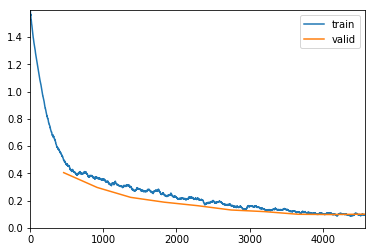

In [56]:
for train_idx, test_idx in sss.split(df.index, df[dep_var]):
    data_fold = (TabularList.from_df(df, path=dataPath, cat_names=cat_names, cont_names=cont_names, procs=procs)
                     .split_by_idxs(train_idx, test_idx)
                     .label_from_df(cols=dep_var)
                     .databunch())
    # create model and learn
    model = tabular_learner(data_fold, layers=[200, 100], metrics=accuracy, callback_fns=ShowGraph)
    model.fit_one_cycle(cyc_len=10) #

In [57]:
model.save('{}.model'.format(os.path.basename(dataPath)))

In [58]:
loss, acc = model.validate()
print('loss {}: accuracy: {:.2f}%'.format(loss, acc*100))

loss 0.10001929849386215: accuracy: 97.22%


In [59]:
preds, y, losses = model.get_preds(with_loss=True)
interp = ClassificationInterpretation(model, preds, y, losses)

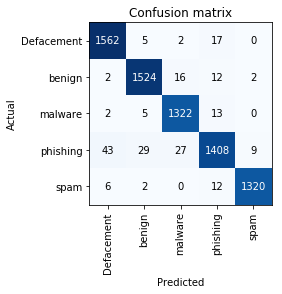

In [60]:
interp.plot_confusion_matrix(slice_size=10)

In [61]:
print(interp.confusion_matrix())

[[1562    5    2   17    0]
 [   2 1524   16   12    2]
 [   2    5 1322   13    0]
 [  43   29   27 1408    9]
 [   6    2    0   12 1320]]


In [62]:
interp.most_confused()

[('phishing', 'Defacement', 43),
 ('phishing', 'benign', 29),
 ('phishing', 'malware', 27),
 ('Defacement', 'phishing', 17),
 ('benign', 'malware', 16),
 ('malware', 'phishing', 13),
 ('benign', 'phishing', 12),
 ('spam', 'phishing', 12),
 ('phishing', 'spam', 9),
 ('spam', 'Defacement', 6),
 ('Defacement', 'benign', 5),
 ('malware', 'benign', 5),
 ('Defacement', 'malware', 2),
 ('benign', 'Defacement', 2),
 ('benign', 'spam', 2),
 ('malware', 'Defacement', 2),
 ('spam', 'benign', 2)]

## Binary-class classification
- Relabel spam, phishing, defacement, malware as 'malicious'
- Keep benign type as benign

In [63]:
lblTypes = list(lblTypes)
lblTypes

['malware', 'spam', 'benign', 'phishing', 'Defacement']

In [64]:
lblTypes = dict(zip(lblTypes, ['malicious']*5))
lblTypes['benign'] = 'benign'
lblTypes

{'malware': 'malicious',
 'spam': 'malicious',
 'benign': 'benign',
 'phishing': 'malicious',
 'Defacement': 'malicious'}

In [68]:
df[label] = df[label].map(lblTypes)

epoch,train_loss,valid_loss,accuracy,time
0,0.156220,0.117772,0.961035,00:04
1,0.111679,0.103802,0.958038,00:05
2,0.103441,0.080355,0.972207,00:04
3,0.084155,0.062802,0.977929,00:04
4,0.073698,0.063454,0.977384,00:04
5,0.066614,0.047918,0.983243,00:04
6,0.045853,0.042428,0.985831,00:04
7,0.042064,0.038307,0.987330,00:04
8,0.028706,0.036385,0.987466,00:04
9,0.032438,0.037092,0.987193,00:04


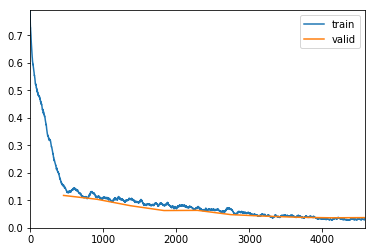

In [69]:
for train_idx, test_idx in sss.split(df.index, df[dep_var]):
    data_fold = (TabularList.from_df(df, path=dataPath, cat_names=cat_names, cont_names=cont_names, procs=procs)
                     .split_by_idxs(train_idx, test_idx)
                     .label_from_df(cols=dep_var)
                     .databunch())
    # create model and learn
    model = tabular_learner(data_fold, layers=[200, 100], metrics=accuracy, callback_fns=ShowGraph)
    model.fit_one_cycle(cyc_len=10)

In [70]:
loss, acc = model.validate()
print('loss {}: accuracy: {:.2f}%'.format(loss, acc*100))

loss 0.03709198907017708: accuracy: 98.72%


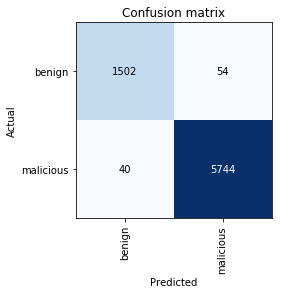

In [71]:
preds, y, losses = model.get_preds(with_loss=True)
interp = ClassificationInterpretation(model, preds, y, losses)
interp.plot_confusion_matrix(slice_size=10)

In [196]:
df1.shape

(36697, 80)